In [1]:
import netket as nk
import netket.experimental as nkx
from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc
from scipy.sparse.linalg import eigsh
import numpy as np
import scipy.sparse.linalg
import jax
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt

import sys, os
sys.path.append('/Users/wttai/Documents/Jupyter/machine_learning/common_lib')
sys.path.append('/home1/wttai/machine_learning/common_lib')
from models import get_qwz_graph, get_qwz_Ham, cdag_, c_
from networks import *
from helper import get_ed_data
import h5py
from tenpy.tools import hdf5_io

/home1/wttai/TeNPy/tenpy/tools/optimization.py:317: UserWarning: Couldn't load compiled cython code. Code will run a bit slower.
  warnings.warn("Couldn't load compiled cython code. Code will run a bit slower.")


In [6]:
import sys, os
sys.path.append('/home1/wttai/machine_learning/netket_qwz/')
L = 2
m = 5.0
t = 1.0
U = 0.0
n_iter = 300
learning_rate = 0.01
diag_shift = 0.05
n_discard_per_chain = 32
n_samples = 8192
n_hidden = 20
model_name = 'nb'


In [70]:
print(f"Teseting configurations for {model}")
command = f"machine_learning/netket_qwz/netket_qwz.py --L={L} --m={m} --t={t} --U={U} --n_hidden={n_hidden} --n_iter={n_iter} --learning_rate={learning_rate} --diag_shift={diag_shift} --n_discard_per_chain={n_discard_per_chain} --n_samples={n_samples} --model={model_name}"
print(command)
get_ipython().run_line_magic("run", command)

Teseting configurations for nj
machine_learning/netket_qwz/netket_qwz.py --L=2 --m=5.0 --t=1.0 --U=0.0 --n_hidden=20 --n_iter=300 --learning_rate=0.01 --diag_shift=0.05 --n_discard_per_chain=32 --n_samples=8192 --model=nb
Program running...
NetKet version:  3.13.0
Initial parameters: m = 5.0, t = 1.0, U = 0.0
Particle number = 4, L = 2, pbc = False


  0%|          | 0/300 [00:00<?, ?it/s]

All done!
Saving into machine_learning/netket_qwz/data/nb_log_L=2_t=1.0_m=5.0_U=0.0.log


/home1/wttai/TeNPy/tenpy/tools/hdf5_io.py:1104: UserWarning: Can't import class FermiHubbardSquare from __main__
  warnings.warn(msg, UserWarning)


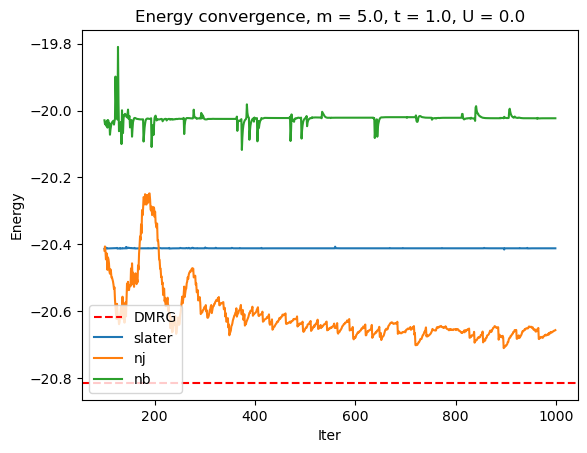

In [15]:
start = 100
end = 1000#n_iter
plt.title(f"Energy convergence, m = {m}, t = {t}, U = {U}")


outputFilename=f"machine_learning/dmrg_qwz/data/dmrg_log_L={L}_t={t}_m={m}_U={U}"
with h5py.File(outputFilename, 'r') as f:
    data_dmrg = hdf5_io.load_from_hdf5(f)
plt.axhline(y=data_dmrg['E0'], color='r', linestyle='--', label='DMRG')  # Adding the horizontal line
e0 = data_dmrg['E0']
model = "slater"
data_slater=json.load(open(f"machine_learning/netket_qwz/data/{model}_log_L={L}_t={t}_m={m}_U={U}.log"))
plt.plot(np.arange(start, end), data_slater['Energy']['Mean']['real'][start:end], label = f"{model}")
model = "nj"
data_nj=json.load(open(f"machine_learning/netket_qwz/data/{model}_log_L={L}_t={t}_m={m}_U={U}.log"))
plt.plot(np.arange(start, end), data_nj['Energy']['Mean']['real'][start:end], label = f"{model}")
model = "nb"
data_nb=json.load(open(f"machine_learning/netket_qwz/data/{model}_log_L={L}_t={t}_m={m}_U={U}.log"))
plt.plot(np.arange(start, end), data_nb['Energy']['Mean']['real'][start:end], label = f"{model}")
plt.xlabel("Iter")
plt.ylabel("Energy")

plt.legend()



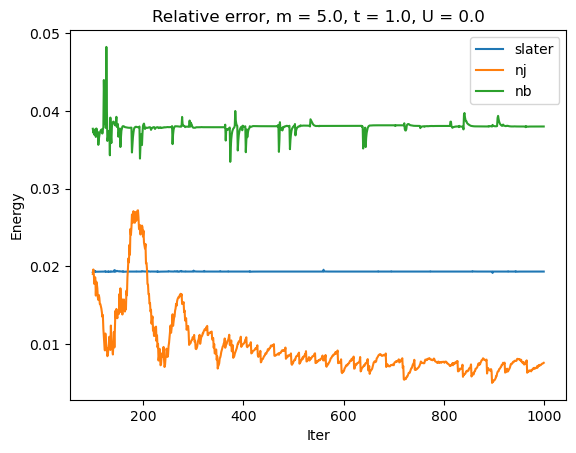

In [17]:
start = 100
end = 1000#n_iter
plt.title(f"Relative error, m = {m}, t = {t}, U = {U}")


outputFilename=f"machine_learning/dmrg_qwz/data/dmrg_log_L={L}_t={t}_m={m}_U={U}"
with h5py.File(outputFilename, 'r') as f:
    data_dmrg = hdf5_io.load_from_hdf5(f)
#plt.axhline(y=data_dmrg['E0'], color='r', linestyle='--', label='DMRG')  # Adding the horizontal line
e0 = data_dmrg['E0']


model = "slater"
data_slater=json.load(open(f"machine_learning/netket_qwz/data/{model}_log_L={L}_t={t}_m={m}_U={U}.log"))
plt.plot(np.arange(start, end), abs((data_slater['Energy']['Mean']['real'][start:end]-e0)/e0), label = f"{model}")
model = "nj"
data_slater=json.load(open(f"machine_learning/netket_qwz/data/{model}_log_L={L}_t={t}_m={m}_U={U}.log"))
plt.plot(np.arange(start, end), abs((data_nj['Energy']['Mean']['real'][start:end]-e0)/e0), label = f"{model}")
model = "nb"
data_nj=json.load(open(f"machine_learning/netket_qwz/data/{model}_log_L={L}_t={t}_m={m}_U={U}.log"))
plt.plot(np.arange(start, end), abs((data_nb['Energy']['Mean']['real'][start:end]-e0)/e0), label = f"{model}")
plt.xlabel("Iter")
plt.ylabel("Energy")

plt.legend()



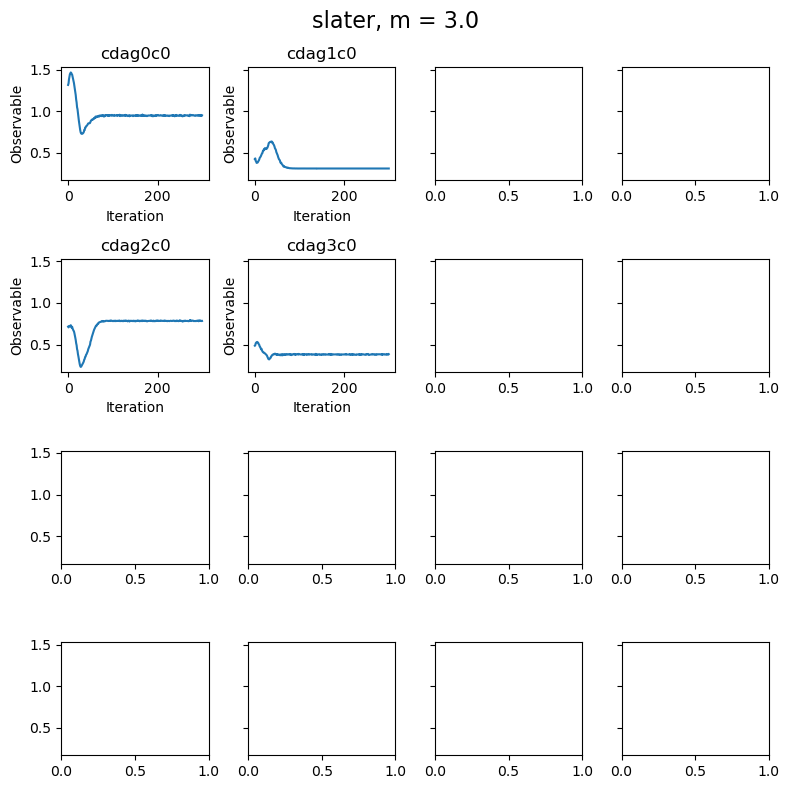

In [36]:
L = 2
N = L ** 2
t = 1.0
m = 3.0
U = 0.0
model = "slater"

data_netket=json.load(open(f"machine_learning/netket_qwz/data/{model}_log_L={L}_t={t}_m={m}_U={U}.log"))


x_values = np.arange(len(data_netket['cdag0c0']['Mean']['real']))

# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 4, figsize=(8, 8), sharey=True)

for i in range(N):
    x = i // L
    y = i % L
    corr = f"cdag{i}c0"
    axs[x][y].plot(x_values, data_netket[corr]['Mean']['real'], label=corr)
    axs[x][y].set_title(corr)
    axs[x][y].set_xlabel('Iteration')
    axs[x][y].set_ylabel('Observable')

fig.suptitle(f'{model}, m = {m}', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


In [17]:
data_dmrg['E0']

-57.06720917538769

In [7]:
import h5py
from tenpy.tools import hdf5_io

outputFilename=f"machine_learning/dmrg_qwz/data/dmrg_log_L={L}_t={t}_m={m}_U={U}"

with h5py.File(outputFilename, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)




# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 4, figsize=(8, 8), sharey=True)

for i in range(N):
    x = i // L
    y = i % L
    corr = f"cdag{i}c0"
    axs[x][y].plot(x_values, data[corr]['Mean']['real'], label=corr)
    axs[x][y].set_title(corr)
    axs[x][y].set_xlabel('Iteration')
    axs[x][y].set_ylabel('Observable')

fig.suptitle(f'{model}, m = {m}', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

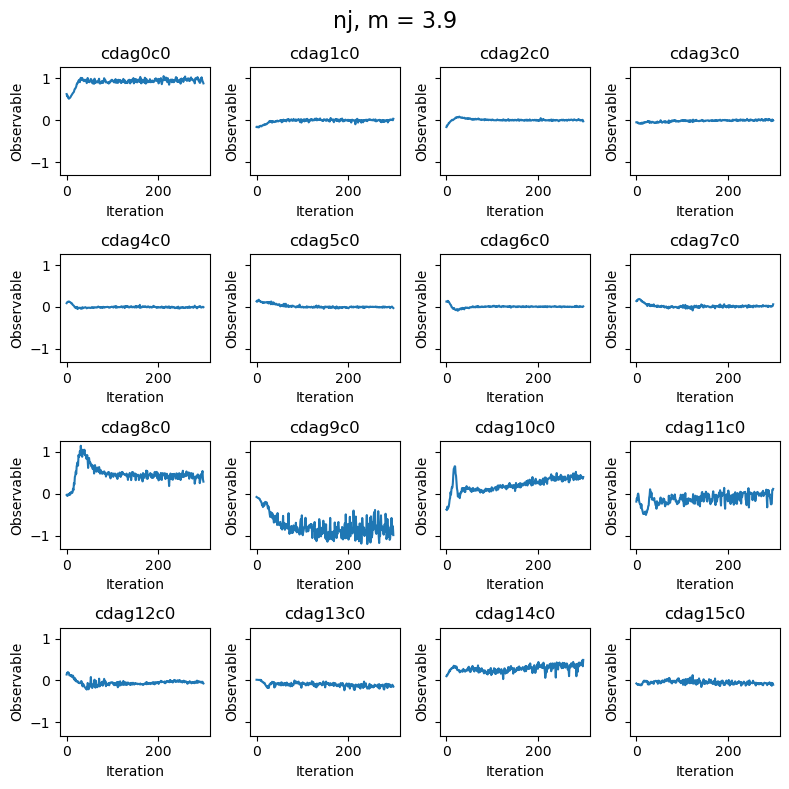

In [31]:
L = 4
N = L ** 2
m = 3.9
model = "nj"

data=json.load(open(f"machine_learning/netket_qwz/data/{model}_log_L={L}_m={m}.log"))


x_values = np.arange(len(data['cdag0c0']['Mean']['real']))

# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 4, figsize=(8, 8), sharey=True)

for i in range(N):
    x = i // L
    y = i % L
    corr = f"cdag{i}c0"
    axs[x][y].plot(x_values, data[corr]['Mean']['real'], label=corr)
    axs[x][y].set_title(corr)
    axs[x][y].set_xlabel('Iteration')
    axs[x][y].set_ylabel('Observable')

fig.suptitle(f'{model}, m = {m}', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


Text(0, 0.5, 'Energy')

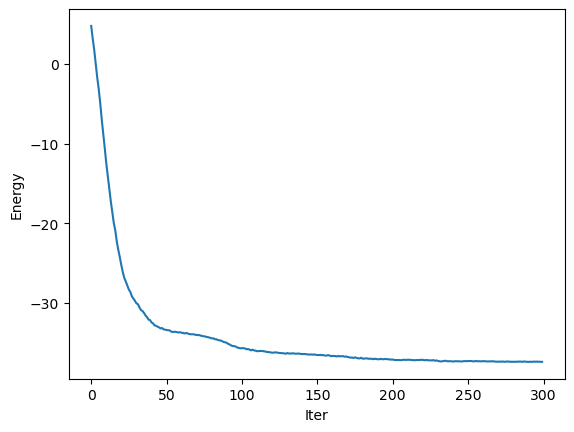